## Importance of Feature Selection

In this notebook I aim to study the importance of feature selection while building a Deep Learning model. I hypothesize that a model would be able to find out the most importance features. So, we can throw all variables in the deep learning models and its performance will not be deteriorated. 

I will check and compare the performance of models built using all features.

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

Using TensorFlow backend.


In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=False)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 24)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 24)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

24

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Experiment

In [22]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):
    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn
    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """
    
    score_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score"])

    for i in range(0, nruns):
        start = time.time()

        model = Sequential()
        model.add(LSTM(
                 units=8,
                 return_sequences=True,
                 input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(
                  units=4,
                  return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])

        model.fit(X, y, epochs=100, batch_size=64, validation_split = 0.1, verbose=0, class_weight=cls_wt,
              shuffle= True ,callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                  verbose=0, mode='auto')])

        predictions = model.predict_classes(X_test)

        acc = accuracy_score(y_test,predictions)
        pr = precision_score(y_test,predictions)
        rc = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)
        auc = roc_auc_score(y_test,predictions)

        score_df = score_df.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr, 'Recall': rc,
                                    'F1 Score': f1, 'AUC Score': auc}, ignore_index=True)
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")        
    
    return score_df

In [24]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns = 10)

Run:1 and Runtime:292.915 Seconds
Run:2 and Runtime:249.298 Seconds
Run:3 and Runtime:252.413 Seconds
Run:4 and Runtime:286.292 Seconds
Run:5 and Runtime:1440.235 Seconds
Run:6 and Runtime:224.546 Seconds
Run:7 and Runtime:226.172 Seconds
Run:8 and Runtime:282.199 Seconds
Run:9 and Runtime:5506.732 Seconds
Run:10 and Runtime:574.399 Seconds


In [28]:
result_df

,Model,Accuracy,Precision,Recall,AUC Score,F1 Score
0,1.0,0.98,0.937500,1.000000,0.985714,0.967742
1,2.0,0.98,0.966667,0.966667,0.976190,0.966667
2,3.0,0.97,0.909091,1.000000,0.978571,0.952381
3,4.0,0.98,0.937500,1.000000,0.985714,0.967742
4,5.0,0.95,0.857143,1.000000,0.964286,0.923077
5,6.0,0.97,0.909091,1.000000,0.978571,0.952381
6,7.0,0.95,0.857143,1.000000,0.964286,0.923077
7,8.0,0.95,0.857143,1.000000,0.964286,0.923077
8,9.0,0.97,0.909091,1.000000,0.978571,0.952381
9,10.0,0.95,0.878788,0.966667,0.954762,0.920635


Text(0, 0.5, 'Value')

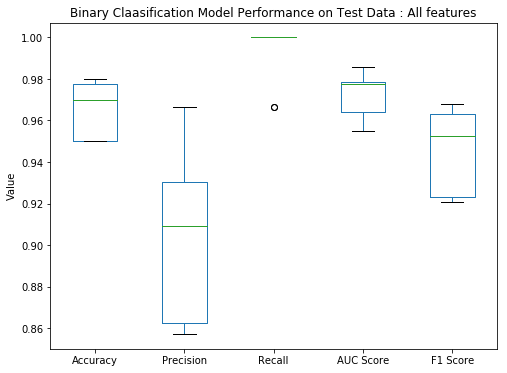

In [29]:
fig, ax = plt.subplots(figsize = (8,6))
result_df.drop(['Model'], axis = 1).boxplot(vert = 1, ax = ax)
ax.set_title('Binary Claasification Model Performance on Test Data : All features')
ax.grid(b=None)
ax.set_ylabel('Value')

In [30]:
result_df.mean()

Model        5.500000
Accuracy     0.965000
Precision    0.901916
Recall       0.993333
AUC Score    0.973095
F1 Score     0.944916
dtype: float64